# Introduction

This dataset contained 100k images all of 64x64 size belonging to 200 classes in train dirrectory. Also I do found some grayscale images in val directory. Since the transfer learning was not allowed, This assignment has followin challenges 

* It will be lot harder to tune HyperParameter and likely take long period to train model
* Due to the small sizer i.e. only 64x64 model have learn to extract features form low resolution images 
* The problem that will be seen most during training is that, the model will overfit a lot due to both of the above



# My Approach

First of I tried many small things trained for every architecture to test out which one perform best for small epochs Turns out **efficientNet** and **Densenet** results were best in all. Inititally I thought of using *MobileNet* but it overfitted very early. There loss curves can be found in logs folder. 

So I trained both EfficientNetB1 and DenseNet parrallel.
After training for around 100 epoch I settled with around 10% val acc and 45% train acc. A lot of overfitting. I noticed two issue
1. output of the model was only of shape (2,2,1280) i.e receptive field was to wide.
2. original model do not have good regularization for this data because it was trained for 220x220 images. 

I addressed this issues as follows:
1. I noticed that the first *stem_conv* had stride of 2 hence it was reducing image to 32x32 initially without taking high resolution info. So, I tried using functional api and directly changing that specific layer attributes but did not work. In the end I had a great idea I exported model as json then manually changed value of stride and padding value of zeropadding layer before it and reconstructed model that worked! This part took me most time to figure out.
2. For the second issue I just looped through layer of reconstructed layers and only changel **l2_Reg_value** of conv2D layers and **dropout_rate** of dropout layer. This was easy and gave me fine control over regularization of the model.

I run a baysina optimizer tuner from Kerastuner to find optimum values of the regulariztion parameters but the values were not working great so I scraped the tuner results and started tuning manually. I found out small value of 1e-6 of l2_reg_rate caused loss to blow up. So I decided to rely on dropouts for regulariztion





# Training details
I trained both models using following scenerios
1. train for some 20-30 epoch on 16x16 size images at very large batch size to warm up the model with small learning rate
2. Then trained for about 100-120 epoch on 32x32 size images at medium batch size to fit model. Off Course both models shown overfitting problem but DenseNet was worse it had train acc of around 97% and val acc of just 28%. Although I was expecting overfitting here this was too much. and densenet did't have dropout layers in architecture. So I droppend the model at this stage. This step was necessary, so that model could **learn to extract features from low resolution images**
3. Then trained for another 100-150 epochs on 64x64 images at small batch size and continued to fine tune models from here and out.

So far I was able to get validation accuarcy of 44.79% on my validation split from train data and train accuarcy of 59.89%. I will update if I acheive any higeher. This training approah worked quiet well and saved me lot of time that would have needed if whole training was done directly on 64x64 images.

# training steps details for EfficientNetB1 model

Setting 1: 
* last_epoch=0,
* epochs=30,
* img_size=16,
* batch_size=2024,
* learning_rate=1e-3,
* dropout_scaler=2.6 

Setting 2:
* last_epoch=30
* epochs=120
* img_size=32
* batch_size=756
* learning_rate=1e-2
* dropout_scaler=3

Setting 3: acc tr=41.76 val=36.82
* last_epoch=150
* epochs=5
* img_size=64
* batch_size=128
* learning_rate=1e-2
* dropout_scaler=2.25 

Setting 4: acc tr=54.81 val=44.48
* last_epoch=155
* epochs=45
* img_size=64
* batch_size=256
* learning_rate=1e-2,
* dropout_scaler=2.25 

setting 5: acc tr=59.91 val=45.79
* last_epoch=200
* epochs=20
* img_size=64
* batch_size=256
* learning_rate=1e-2
* dropout_scaler=2.6

# Loading Data from Gdrive and importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip -q "/content/gdrive/MyDrive/Colab/Assignment/Data/archive.zip" -d /content/Data

In [4]:
from tensorflow.keras.layers.experimental import preprocessing as pl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
import tensorflow.keras.layers as l
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import random
import json
import os

# Set directories here

In [5]:
# Hyperparameters and directories

PROJ_DIR = "/content/gdrive/MyDrive/Colab/Assignment"
TRAIN_DIR = "/content/Data/tiny-imagenet-200/train"
TEST_DIR = "/content/Data/tiny-imagenet-200/val"

img_size       =  64
batch_size     =  512
learning_rate  =  1e-2

# Results

In [6]:
train_csv = pd.read_csv(os.path.join(PROJ_DIR, 'train.csv'))
datagen = ImageDataGenerator(validation_split=0.2)
train_gen = datagen.flow_from_dataframe(
    train_csv, directory=TRAIN_DIR, x_col='image_path', y_col='class_name',
    weight_col=None, target_size=(img_size, img_size), class_mode='categorical', 
    batch_size=batch_size, shuffle=True,subset="training")
val_gen = datagen.flow_from_dataframe(
    train_csv, directory=TRAIN_DIR, x_col='image_path', y_col='class_name',
    weight_col=None, target_size=(img_size, img_size), class_mode='categorical', 
    batch_size=batch_size, shuffle=False,subset="validation")

Found 80000 validated image filenames belonging to 200 classes.
Found 20000 validated image filenames belonging to 200 classes.


Loading latest model with best val accuary

In [7]:
# List all models 
efficient_best_check = os.path.join(PROJ_DIR, "models", "Effnetnet_64_201_220.h5")
effnet = tf.keras.models.load_model(efficient_best_check)

loss = tf.keras.losses.CategoricalCrossentropy()
adam_opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
opt = tfa.optimizers.MovingAverage(adam_opt)

metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')]
effnet.compile(loss=loss, optimizer=opt, metrics=metrics)

effnet.summary()

Model: "Effnet_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Augumentation (Sequent (None, 64, 64, 3)         0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 4, 4, 1280)        6575239   
_________________________________________________________________
Global_Average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
Classifier (Dense)           (None, 200)               256200    
Total params: 6,831,439
Trainable params: 6,769,384
Non-trainable params: 62,055
_________________________________________________________________


train_accuracy:
* Top1 :- 59.89
* Top5 :- 84.12

Validation  Accuracy:
* Top1 :- 45.79 
* Top5 :- 72.39

In [9]:
train_rec = effnet.evaluate(train_gen,steps=train_gen.samples//batch_size, verbose=0)
val_rec   = effnet.evaluate(val_gen,steps=val_gen.samples//batch_size, verbose=0)

print(f"train top1 accuracy = {train_rec[1]} val top1 accuracy = {val_rec[1]}")
print(f"train top5 accuracy = {train_rec[2]} val top5 accuracy = {val_rec[2]}")

train top1 accuracy = 0.5989833474159241 val top1 accuracy = 0.4578826129436493
train top5 accuracy = 0.8418970108032227 val top5 accuracy = 0.7238581776618958


Model inference time

for CPU - 37 images/second

for GPU - 1373 images/second

In [10]:
from time import time
val_images = 20000

start = time()
effnet.evaluate(val_gen,steps=val_gen.samples//batch_size, verbose=1)
end = time()

time_per_image = (end-start)/val_images
print(f"time per image {time_per_image} \nimages per second  {1/time_per_image} ")

39/39 [==============================] - 14s 365ms/step - loss: 2.2754 - categorical_accuracy: 0.4579 - top_5_categorical_accuracy: 0.7239
time per image 0.0007285184502601623 
images per second  1372.648832219539 


# Extra context for evaluating model

Find top k classes most accuarte classes

40/40 [==============================] - 16s 364ms/step


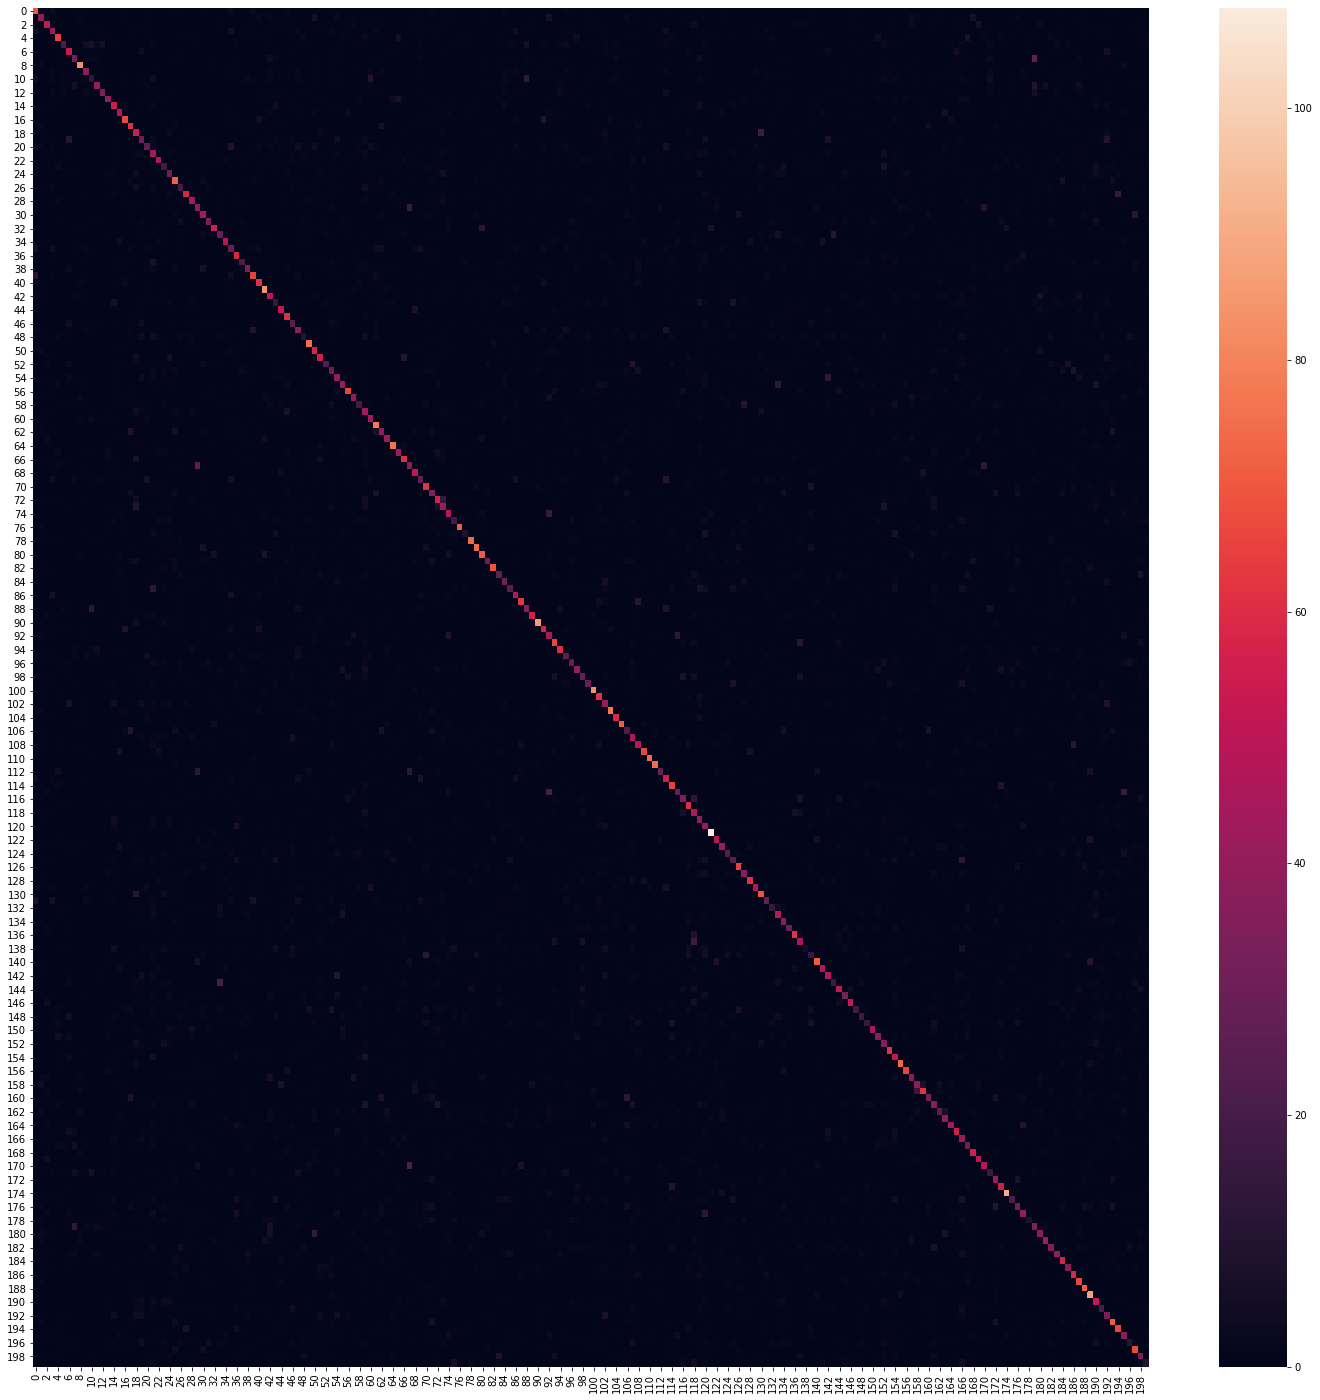

In [12]:
# Confusion Matrix 
predicted_labels = effnet.predict(val_gen,steps=1+val_gen.samples//batch_size,verbose=1)
predicted_labels = np.argmax(predicted_labels, axis=-1)
true_labels = np.array(val_gen.classes)
confus_mat = tf.math.confusion_matrix(true_labels, predicted_labels).numpy()
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(confus_mat, ax=ax)

In [13]:
# calculate per class accuracy
k = 10

# Get indices to label map
label_map = {}
for key,value in train_gen.class_indices.items():
    label_map[value]=key

# Get top k classes
total_per_class=np.sum(confus_mat, axis=-1)
correct_per_class = [confus_mat[i,i] for i in range(200)]
accuracy_per_class = (correct_per_class/total_per_class)*100
sorted_per_acc = accuracy_per_class.argsort().tolist()[::-1]

top_k = [["label", "index", "accuracy"]]
for i in sorted_per_acc[:k]:
    top_k.append([label_map[i], i, round(accuracy_per_class[i],2)])

for row in top_k:
    print("{: <100} {: <10} {: <30}".format(*row))

label                                                                                                index      accuracy                      
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus                                     121        90.76                         
sulphur butterfly, sulfur butterfly                                                                  174        83.49                         
lifeboat                                                                                             111        82.42                         
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens                                  110        81.52                         
European fire salamander, Salamandra salamandra                                                      8          81.37                         
trolleybus, trolley coach, trackless trolley                                                         189        81.31                         

Visualize model outputs with images from val directory 

Note-The images visualized below are neither in train or val set during training and they are chosen randomly from pile

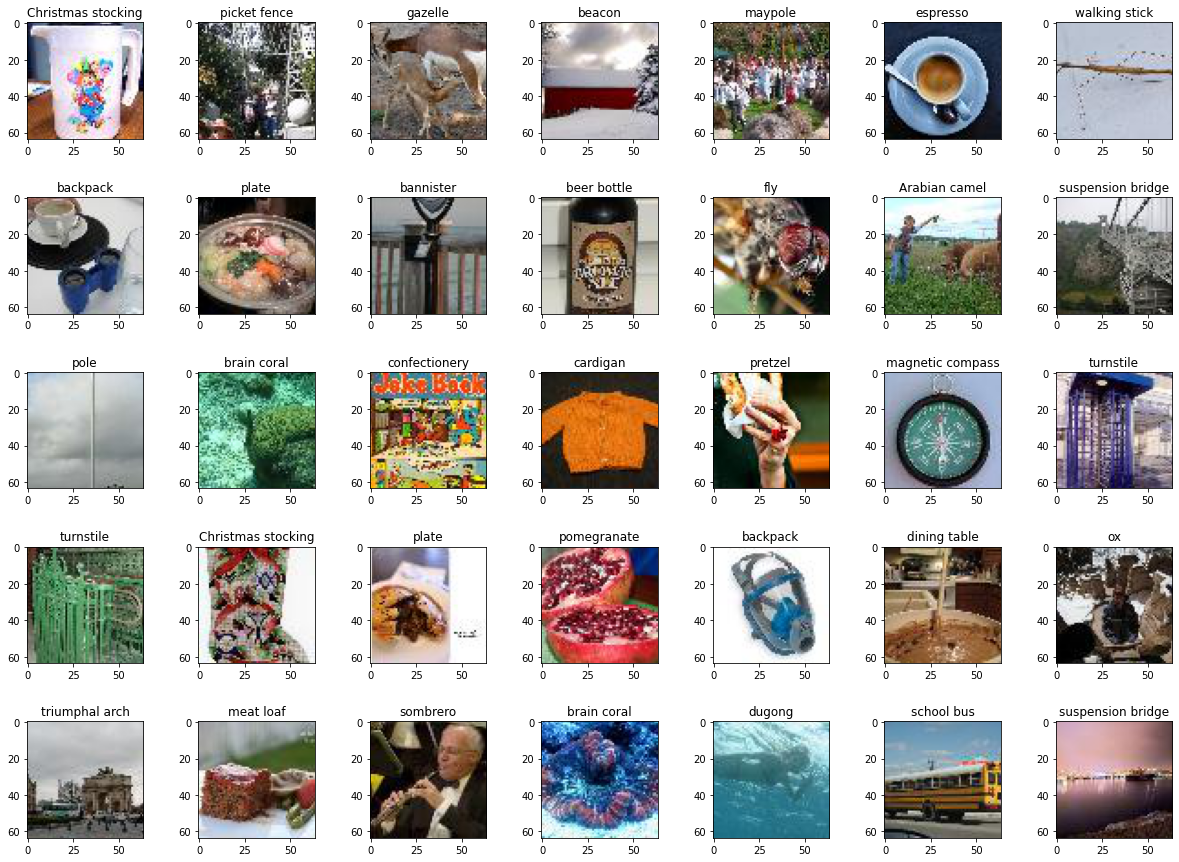

In [14]:
# change img_row and img_col to change examples
img_row = 5
img_col = 7
images_to_visualize = img_row*img_col


images = os.listdir(os.path.join(TEST_DIR,"images"))
images = [random.choice(images) for _ in range(images_to_visualize+10)]
img_iter = iter(images)

fig, ax = plt.subplots(img_row,img_col, figsize=(21,15))
plt.subplots_adjust(hspace=0.5)

for i in range(img_row):
    for j in range(img_col):
        image = next(img_iter)
        pil_img = Image.open(os.path.join(TEST_DIR,"images",image), 'r')
        try:
            img_arr = np.expand_dims(np.asarray(pil_img), axis=0)
            class_idx = np.argmax(effnet.predict_step(img_arr))
        except:
            print(image, img_arr.shape)
        class_pred = label_map[class_idx]
        ax[i][j].imshow(np.asarray(pil_img))
        ax[i][j].title.set_text(class_pred.split(', ')[0])

# Model loss acc graphs

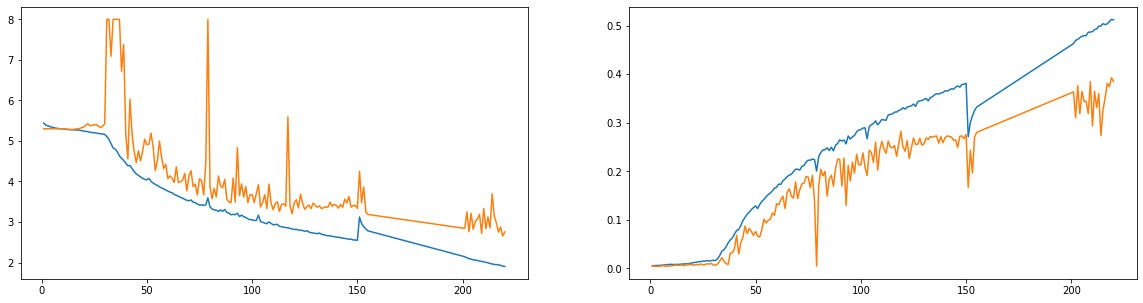

In [15]:
log_dfs_dir =[x for x in os.listdir(os.path.join(PROJ_DIR, "Logs")) if x.startswith("EffNET")]
log_dfs = []
for df in log_dfs_dir:
    log_dfs.append(pd.read_csv(os.path.join(PROJ_DIR, "Logs", df)))

log_df = pd.concat(log_dfs).sort_values(by="epoch")

fig, axes = plt.subplots(1,2, figsize=(20,5))
plt.subplots_adjust(hspace = 0.3)

axes[0].plot(log_df["epoch"], log_df["loss"], label="train_loss")
axes[0].plot(log_df["epoch"], log_df["val_loss"].clip(0,8), label="val_loss")
axes[1].plot(log_df["epoch"], log_df["categorical_accuracy"], label="train_accuracy")
axes[1].plot(log_df["epoch"], log_df["val_categorical_accuracy"], label="val_accuracy")